# Paradoja de Monty Hall; Simulación, ML & Demostración.

## Introducción
La paradoja de Monty Hall es un problema clásico de probabilidad que proviene de un programa de televisión estadounidense llamado "Let's Make a Deal", presentado por Monty Hall. El problema se presenta de la siguiente manera:

Estás en un concurso donde tenemos tres puertas cerradas, detrás de una hay un premio y de las otras dos una cabra (o algo sin valor, se dicen cabras porque así era originalmente). Como concursante has de elegir una puerta al azar, que al seleccionarla el presentador del concurso, que sabe donde está el premio, te abre una de las otras dos puertas en la cual te muestra que hay una cabra en ella, después de ello, te hace la siguiente pregunta: 

*¿Te mantienes con la puerta que elegiste inicialmente, o quieres cambiar a la otra puerta que se encuentra cerrada?*

Aunque parece que cambiar de puerta no debería generar ninguna diferencia en las probabilidades de ganar el premio, la mejor estrategia es siempre cambiar de puerta. Al cambiar de puerta, tus probabilidades de ganar el premio aumentan de 1/3 a 2/3.

Con esta premisa, se hará una simulación que replique el experimento un número de veces determinado, se realizará un sencillo modelado de Machine Learning del experimento con Scikit-Learn que se entrenará para predecir las probabilidades de ganar el premio según la decisión de cambiar de puerta o no, y posteriormente se expondrá la demostración matemática del problema, recurriendo a la estadística e inferencia bayesiana.

## Simulación y Diseño del Experimento.

Importamos y cargamos las librerías necesarias para este apartado.

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

Denotamos el número de replicaciones y creamos el diccionario con los posibles distintos sucesos del experimento. Entendemos por victoria cuando tras la decisión final de cambiar de puerta o no, la puerta seleccionada contiene el premio, y por derrota, viceversa.

In [3]:
replicaciones = 10000
resultados = {
    'Victoria sin cambio de puerta': 0,
    'Victoria con cambio de puerta': 0,
    'Derrota sin cambio de puerta': 0,
    'Derrota con cambio de puerta': 0,
}

Definimos la función experimento según las características de la Paradoja de Monty-Hall.

In [4]:
def experimento():
    puertas = range(1, 4)
    premio = random.choice(puertas)
    seleccion = random.choice(puertas)

    opciones_no_premio = [puerta for puerta in puertas if puerta != premio and puerta != seleccion]
    no_premio = random.choice(opciones_no_premio)

    opciones_sin_no_premio = [puerta for puerta in puertas if puerta != no_premio]
    nueva_seleccion = random.choice(opciones_sin_no_premio)

    return premio, seleccion, nueva_seleccion

Realizamos la simulación del experimento según el número de replicaciones establecido.

In [5]:
for i in range(replicaciones):
    premio, seleccion, nueva_seleccion = experimento()

    if nueva_seleccion == seleccion:
        if nueva_seleccion == premio:
            resultados['Victoria sin cambio de puerta'] += 1
        else:
            resultados['Derrota sin cambio de puerta'] += 1
    else:
        if nueva_seleccion == premio:
            resultados['Victoria con cambio de puerta'] += 1
        else:
            resultados['Derrota con cambio de puerta'] += 1

Representamos y visualizamos los resultados de las replicaciones del experimento.

In [6]:
resultados_pd = pd.DataFrame(list(resultados.items()), columns=['Suceso', 'Cantidad'])

print(resultados_pd.to_string(index=False))

                       Suceso  Cantidad
Victoria sin cambio de puerta      1662
Victoria con cambio de puerta      3330
 Derrota sin cambio de puerta      3248
 Derrota con cambio de puerta      1760


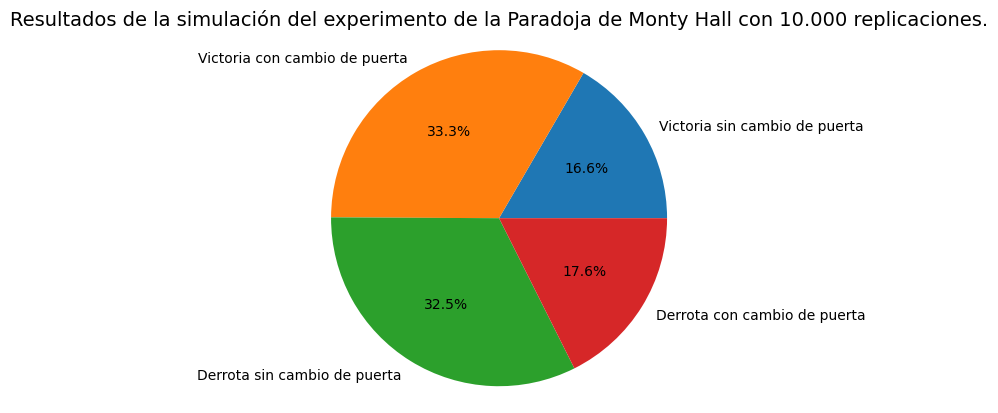

In [7]:
labels = list(resultados.keys())
sizes = list(resultados.values())

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Resultados de la simulación del experimento de la Paradoja de Monty Hall con 10.000 replicaciones.', fontsize=14)
plt.axis('equal')
plt.show()

Observando los resultados tras las 10.000 replicaciones del experimento, podemos decir que es cierto que al cambiar de puerta, tus probabilidades de ganar el premio aumentan de 1/3 a 2/3. Esto lo podemos ver tanto comparando los sucesos 'Victoria con cambio de puerta' y 'Victoria sin cambiar de puerta', como comparando los sucesos 'Victoria con cambio de puerta' y 'Derrota con cambio de puerta'.

## Modelización Predictiva y ML.

El resultado de la simulación expuesto, lo podemos simplificar en un dataframe que esté estructurado con las dos variables siguientes: "Premio", para evaluar si ganó el premio (0 = Perdió, 1 = Ganó) y "Cambio_Puerta", para indicar si cambió de puerta (0 = No cambió, 1 = Sí cambió).

Creamos, generamos y visualizamos el dataframe con los datos con los que se hará la división en conjunto de entrenamiento y prueba, para posteriormente entrenar y evaluar el modelo.

In [8]:
def generar_datos(replicaciones):
    datos = []
    for _ in range(replicaciones):
        premio, seleccion, nueva_seleccion = experimento()
        
        Premio = 1 if nueva_seleccion == premio else 0
        Cambio_Puerta = 1 if nueva_seleccion != seleccion else 0

        datos.append([Premio, Cambio_Puerta])
    
    return pd.DataFrame(datos, columns=['Premio', 'Cambio_Puerta'])

In [9]:
df_MH = generar_datos(replicaciones)
df_MH.tail()

,Premio,Cambio_Puerta
9995,0,0
9996,1,1
9997,1,1
9998,0,1
9999,0,1


Para elegir el modelo adecuado, adelantamos que la Paradoja de Monty Hall se fundamenta en la Estadística Bayesiana y el Teorema de Bayes. Por lo tanto, ¿qué modelo podría ser más apropiado que el de Naive-Bayes para desarrollar este análisis?

Decidimos entonces el modelo de Naive-Bayes debido a que se basa explicitamente en el Teorema de Bayes. Importamos y cargamos todas las funciones necesarias de la librería de Scikit_Learn.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

Separamos en **y** la variable objetivo y en **X** las predictoras, en este caso solo tenemos una variable predictora debido a la simplicidad a la que hemos reducido el experimento. Luego, realizamos la división de datos en conjuntos de un 70% para el entrenamiento y un 30% para la prueba.

In [11]:
X = df_MH[['Cambio_Puerta']]
y = df_MH['Premio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=61)

Entrenamos el modelo según Naive-Bayes. Posteriormente evaluamos el modelo junto a las predicciones.

In [12]:
modelo = GaussianNB()
modelo.fit(X_train, y_train)

predicciones = modelo.predict(X_test)
accuracy = accuracy_score(y_test, predicciones)

print(f"Exactitud del modelo: {accuracy}")
print(f"Reporte de clasificación:\n {classification_report(y_test, predicciones)}")

Exactitud del modelo: 0.6743333333333333
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.68      0.67      0.67      1502
           1       0.67      0.68      0.67      1498

    accuracy                           0.67      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.67      0.67      0.67      3000



Observamos que tenemos una *exactitud* del modelo de un 67.433%. En el reporte de clasificación, *precisión* (precision) mide qué porcentaje de las predicciones de las clases *'Premio'* son correctas, mientras que la *exhaustividad* (recall) mide qué porcentaje de los casos reales de las clases de *'Premio'* fueron correctamente predichas. En las *cargas* (support), podemos ver el número total de casos de la muestra de los datos de prueba para cada clase.

Para tener una mejor visualización de esto, representamos la matriz de confusión del modelo.

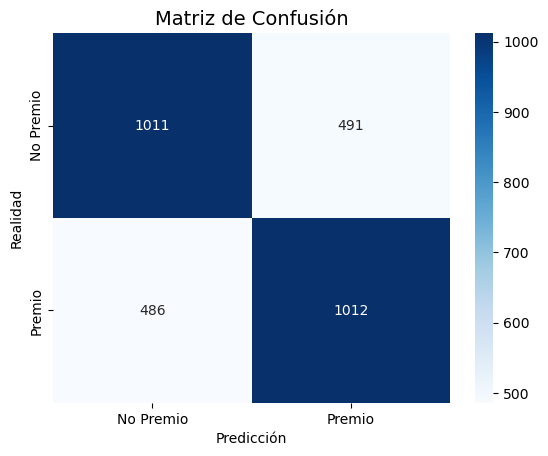

In [13]:
sns.heatmap(confusion_matrix(y_test, predicciones), 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['No Premio', 'Premio'], 
            yticklabels=['No Premio', 'Premio'])
plt.title('Matriz de Confusión', fontsize=14)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

Se observa que el modelo predice correctamente 2/3 de los casos que ha dictaminado tanto ganar premio como no ganar premio, según la variable *'Cambio_Puerta'*.

Como conclusión, el valor de *exactitud* del modelo Naive-Bayes (67.433%), está alineado con la teoría ya expuesta. Esto indica que el modelo reconoce el patron propio a los datos generados por la paradoja. Además, la *precisión* y *exhaustividad* de ambas clases (0 y 1) son similares, lo que significa que el modelo no favorece ni penaliza en exceso ninguna opción (cambiar o no cambiar) más allá de los efectos de las probabilidades dadas como premisa al cambiar o no cambiar de puerta.

Por último, se representa gráficamente cómo la variable *'Cambio_Puerta'* afecta la probabilidad de ganar según el modelo, con el promedio de las observaciones posteriores al modelado.

In [14]:
probabilidades = modelo.predict_proba(X)[:, 1]

visualizacion_df_MH = pd.DataFrame({'Cambio_Puerta': X['Cambio_Puerta'],
                                 'Probabilidad_Predicha': probabilidades})

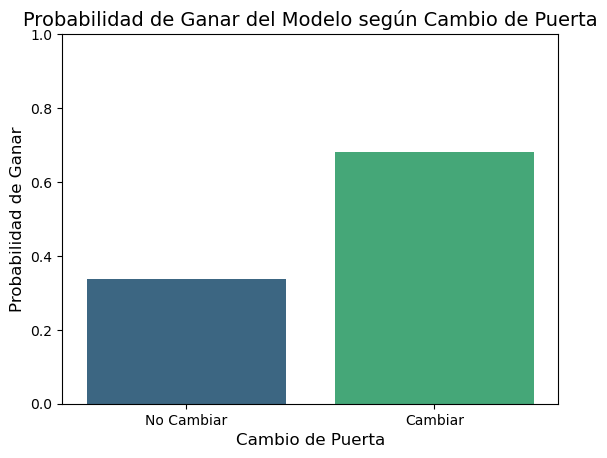

In [15]:
probabilidades_promedio = visualizacion_df_MH.groupby('Cambio_Puerta')['Probabilidad_Predicha'].mean()

sns.barplot(x = probabilidades_promedio.index,
            y = probabilidades_promedio.values,
            palette ='viridis')

plt.title('Probabilidad de Ganar del Modelo según Cambio de Puerta', fontsize = 14)
plt.xlabel('Cambio de Puerta', fontsize = 12)
plt.ylabel('Probabilidad de Ganar', fontsize = 12)
plt.xticks([0, 1], labels=['No Cambiar', 'Cambiar'])
plt.ylim(0, 1)
plt.show()

## Demostración Matemática de la Paradoja de Monty Hall.

Para los más curiosos dejo la demostracíon de la Paradoja clásica de Monty Hall donde hay 3 puertas y un premio, y por consecuencia el presentador solo puede abrir una puerta. Para ello recurrimos a los fundamentos de la estadística, probablidad y desarrollo bayesiano:

Teorema de Bayes: Es la expresión de probabilidad condicionada, cuyo valor es la eventualidad de que ocurra un suceso $B$, como consecuencia de otro suceso $A$, y se denota por $P(B|A)$. Se calcula utilizando la siguiente expresión:
$$
    P(B|A) = \frac{P(A|B)·P(B)}{P(A)}
$$
Tenemos los siguientes sucesos:

- $P$ = {$P1$: Suceso el premio está en la puerta 1, $P2$: Suceso el premio está en la puerta 2, $P3$: Suceso el premio está en la puerta 3}
- $Q$ = {$Q1$: Suceso el presentador abre la puerta 1, $Q2$: Suceso el presentador abre la puerta 2, $Q3$: Suceso el presentador abre la puerta 3}

Ahora, situémonos en el hipotético escenario en el que hemos elegido una puerta aleatoriamente, por ejemplo la puerta 1, y el presentador nos muestra una cabra tras la puerta 2, por ejemplo. Desde este punto tenemos dos posibles escenarios:
$$
    P(P1|Q2) = \frac{P(Q2|P1)·P(P1)}{P(Q2)}
$$
$$
    P(P3|Q2) = \frac{P(Q2|P3)·P(P3)}{P(Q2)}
$$
Matizar y recalcar que las probabilidades no condicionadas son probabilidades a priori, y las probabilidades condicionadas, es decir, cuando el presentador abre una puerta, son probabilidades a posteriori. Además, el premio solo puede estar en la puerta 1 o 3: 
$$
    P(P1|Q2) + P(P3|Q2) = 1.
$$
Entonces, como las probabilidades a priori $P(P1) = P(P3)$ y $P(P1|Q2) + P(P3|Q2) = 1$, la única diferencia entre las probablididades $P(P1|Q2)$ y $P(P3|Q2)$ está dada por sus repectivos 'likelihood' que son $P(Q2|P1)$ y $P(Q2|P3)$. Por lo tanto:

- La probabilidad de que el presentador abra la puerta 2 estando el premio en la puerta 1 $P(Q2|P1) = 1/2$, dado que el presentador puede abrir la puerta 2 o 3.
- Sin embargo, la probabilidad de que el presentador abra la puerta 2 estando el premio en la puerta $3 P(Q2|P1) = 1$, porque la puerta 3 no la puede abrir debido a que ahí se encuentra el premio.

Como resultado, tenemos que:
$$
     \frac{P(P1|Q2)}{P(Q2|P1)} = \frac{P(P3|Q2)}{P(Q2|P3)}
$$
$$
    \frac{P(P1|Q2)}{1/2} = P(P3|Q2)
$$
$$
    2·P(P1|Q2) = P(P3|Q2)
$$
Entonces:
$$
    P(P1|Q2) + P(P3|Q2) = 1
$$
$$
    P(P1|Q2) + 2·P(P1|Q2) = 1
$$
$$
    3·P(P1|Q2) = 1
$$
Por último, como: 
$$
    P(P1|Q2) = 1/3
$$
$$
    P(P3|Q2) = 2/3
$$

De esta manera, el análisis realizado en este notebook ha abordado la paradoja de Monty Hall desde diferentes perspectivas, confirmando los resultados teóricos mediante simulación, modelado de machine learning y demostración matemática.

La simulación del experimento a través de un gran número de iteraciones demostró empíricamente que la mejor estrategia es siempre cambiar de puerta. El modelo Naive-Bayes entrenado con Scikit-Learn ha respaldado la relación entre la decisión de cambiar de puerta y las probabilidades de ganar el premio, esto refuerza el papel de las herramientas de aprendizaje automático para validar hipótesis y resolver problemas probabilísticos de toma de decisiones. Por último, a través del uso de probabilidad condicional e inferencia bayesiana, se ha expuesto matemáticamente que cambiar de puerta maximiza las probabilidades de ganar, resolviendo la paradoja desde una perspectiva matemática.

## Autor: Alfonso Guisado González